**<h1 align="center"> Projet de Text Mining : Summarization de Texte avec le Modèle BART (Transformer) <h1>**

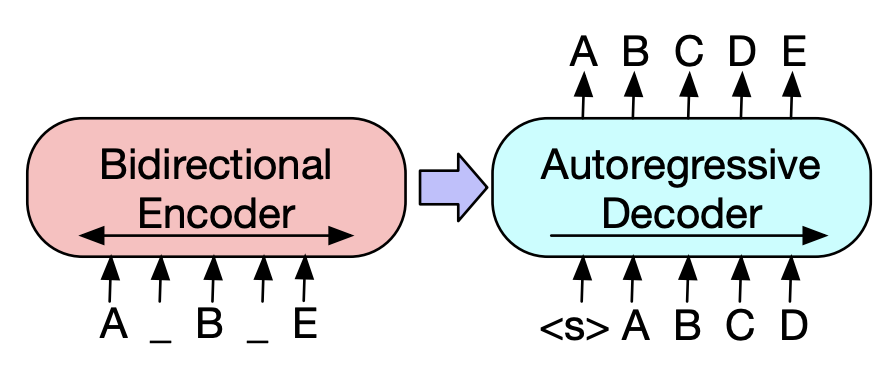

#Étape 1 : Collecte et préparation des données

##Connection au drive

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Collecte de données : Le web Scraping

In [18]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd

# Fonction pour le web scraping
def scrap_wikipedia(url):
    page = urlopen(url)
    soup = BeautifulSoup(page)
    text = ' '.join(map(lambda p : p.text, soup.find_all('p')))
    print(soup.title.text)
    print(text)
    return soup.title.text,text

# URL de la page d'accueil de Wikipedia en français
url_wikipedia = 'https://en.wikipedia.org/wiki/Nobel_Prize'

# Scraper les titres des articles
title, text = scrap_wikipedia(url_wikipedia)

Nobel Prize - Wikipedia

 The Nobel Prizes (/noʊˈbɛl/ noh-BEL; Swedish: Nobelpriset [nʊˈbɛ̂lːˌpriːsɛt]; Norwegian: Nobelprisen Norwegian: [nʊˈbɛ̀lːˌpriːsn̩] ⓘ) are five separate prizes that, according to Alfred Nobel's will of 1895, are awarded to "those who, during the preceding year, have conferred the greatest benefit to humankind." Alfred Nobel was a Swedish chemist, engineer, and industrialist most famously known for the invention of dynamite. He died in 1896. In his will, he bequeathed all of his "remaining realisable assets" to be used to establish five prizes which became known as "Nobel Prizes". Nobel Prizes were first awarded in 1901.[2]
 Nobel Prizes are awarded in the fields of Physics, Chemistry, Physiology or Medicine, Literature, and Peace (Nobel characterised the Peace Prize as "to the person who has done the most or best to advance fellowship among nations, the abolition or reduction of standing armies, and the establishment and promotion of peace congresses").[2] In 1

## Pre-processing : étude statistique (exploration des données)

In [19]:
print(title)

Nobel Prize - Wikipedia


In [20]:
print(text[:153])


 The Nobel Prizes (/noʊˈbɛl/ noh-BEL; Swedish: Nobelpriset [nʊˈbɛ̂lːˌpriːsɛt]; Norwegian: Nobelprisen Norwegian: [nʊˈbɛ̀lːˌpriːsn̩] ⓘ) are five separate


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


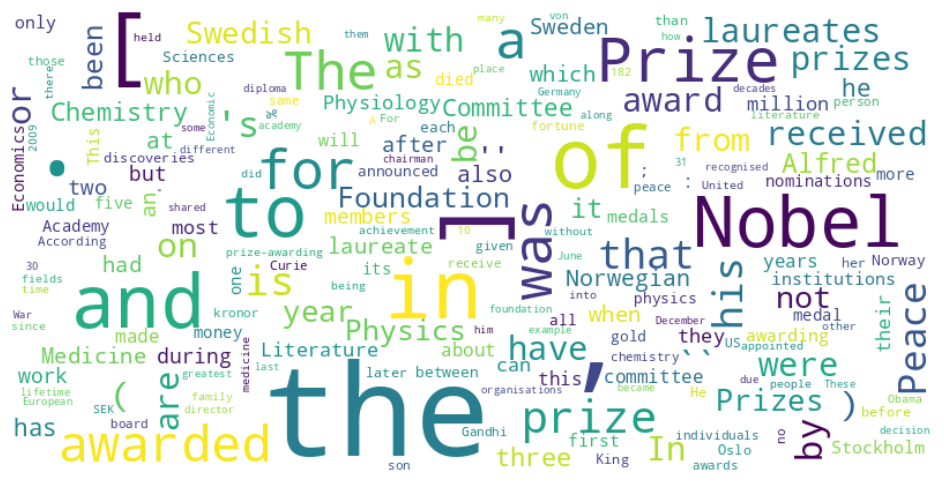

In [21]:
import nltk
from nltk import FreqDist
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Téléchargement des ressources nécessaires pour nltk
nltk.download('punkt')

# Tokenisation des mots
words = nltk.word_tokenize(text)

# Création d'une distribution de fréquence
freq_dist = FreqDist(words)

# Création d'un nuage de mots
wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, background_color='white').generate_from_frequencies(freq_dist)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

text_sans_mot_vide=""
word =""
for caractere in text :
  if caractere !=" ":
    word+=caractere.lower()
  else:
    if word not in stop_words:
      text_sans_mot_vide+=word+" "
    word=""

# Création d'une liste de textes (dans notre cas, un seul texte)
corpus = [text_sans_mot_vide]
# Initialisation du vectoriseur TF-IDF
vectorizer = TfidfVectorizer()

# Calcul des scores TF-IDF
tfidf_matrix = vectorizer.fit_transform(corpus)

# Obtention des noms des mots (features)
feature_names = vectorizer.get_feature_names_out()

# Création d'un DataFrame pour afficher les scores TF-IDF
df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# Tri par ordre décroissant des scores TF-IDF pour obtenir les mots les plus pertinents
top_words = df.transpose().sort_values(0, ascending=False).head(3)

# Affichage des 5 mots les plus pertinents
print(top_words)

                0
prize    0.602725
nobel    0.513310
awarded  0.268246


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
# Convertir les pertinences en pourcentage
top_words_percentage = (top_words[0] * 100).round(2)

# Convertir top_words_percentage en un dictionnaire
top_words_dict = top_words_percentage.to_dict()

# Convertir le dictionnaire en une liste de tuples (mot, pertinence en pourcentage)
top_words_list = list(top_words_dict.items())

# Afficher la liste des mots avec leur pertinence en pourcentage
print(top_words_list)


[('prize', 60.27), ('nobel', 51.33), ('awarded', 26.82)]


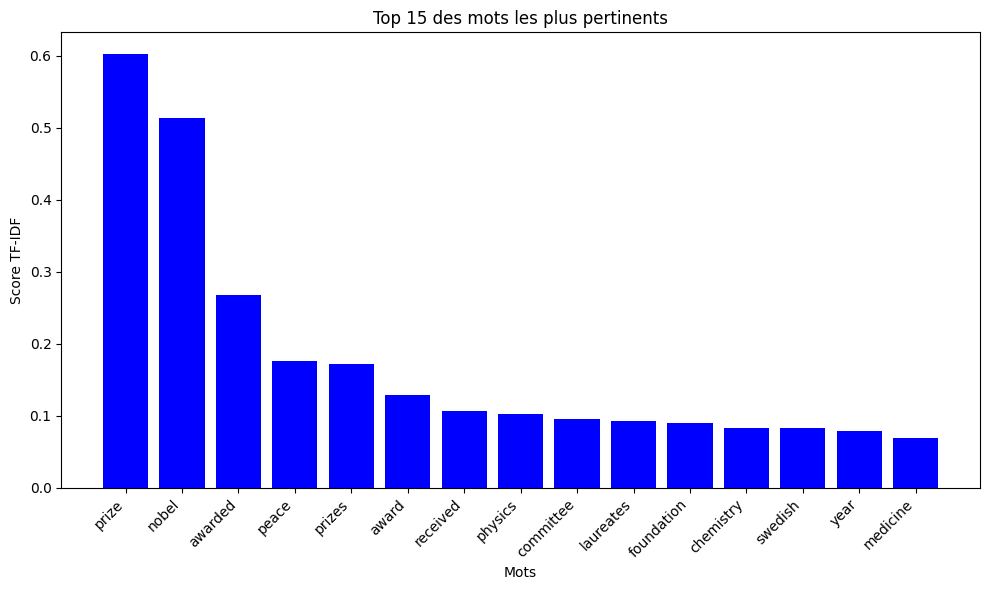

In [24]:
import matplotlib.pyplot as plt

# Utiliser le résultat de l'exemple précédent pour les top_words
top_words = df.transpose().sort_values(0, ascending=False).head(15)

# Tracer un diagramme à barres
plt.figure(figsize=(10, 6))
plt.bar(top_words.index, top_words[0], color='blue')
plt.xlabel('Mots')
plt.ylabel('Score TF-IDF')
plt.title('Top 15 des mots les plus pertinents')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Afficher le diagramme
plt.show()


#Étape 2 : Création et évaluation des modèles

##Création du modèle : summarisation text with generating tools (BART)

In [25]:
from transformers import BartTokenizer, BartForConditionalGeneration

# Charger le modèle BART et le tokenizer
model_name = "facebook/bart-large-cnn"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

In [26]:
# Fonction de summarization
def summarize_text(text,max_length=150):
    # Tokenization : pretraitement et netroyage de données
    inputs = tokenizer(text, return_tensors="pt", max_length=1024, truncation=True)

    # Générer le résumé
    summary_ids = model.generate(inputs["input_ids"], max_length=max_length, min_length=50, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    return summary

In [27]:
# Exemple d'utilisation
summary_result = summarize_text(text,1000)

print("Texte d'origine :")
print(text)
print("\nRésumé :")
print(summary_result)

Texte d'origine :

 The Nobel Prizes (/noʊˈbɛl/ noh-BEL; Swedish: Nobelpriset [nʊˈbɛ̂lːˌpriːsɛt]; Norwegian: Nobelprisen Norwegian: [nʊˈbɛ̀lːˌpriːsn̩] ⓘ) are five separate prizes that, according to Alfred Nobel's will of 1895, are awarded to "those who, during the preceding year, have conferred the greatest benefit to humankind." Alfred Nobel was a Swedish chemist, engineer, and industrialist most famously known for the invention of dynamite. He died in 1896. In his will, he bequeathed all of his "remaining realisable assets" to be used to establish five prizes which became known as "Nobel Prizes". Nobel Prizes were first awarded in 1901.[2]
 Nobel Prizes are awarded in the fields of Physics, Chemistry, Physiology or Medicine, Literature, and Peace (Nobel characterised the Peace Prize as "to the person who has done the most or best to advance fellowship among nations, the abolition or reduction of standing armies, and the establishment and promotion of peace congresses").[2] In 1968, S

In [28]:
len(summary_result)

397

In [29]:
len(text.split())

6818

## Justification du choix du model
Le choix du modèle `BartForConditionalGeneration` pour la tâche de text summarization est motivé par plusieurs raisons :

1. **Spécifiquement conçu pour la génération de texte :** BART (Bidirectional and Auto-Regressive Transformers) est un modèle qui a été pré-entraîné spécifiquement pour la génération de texte. Il a montré de bonnes performances dans des tâches de génération, ce qui inclut la text summarization.

2. **Bidirectionnel et auto-régressif :** BART est bidirectionnel, ce qui signifie qu'il prend en compte le contexte à la fois à gauche et à droite d'un mot. Cela permet au modèle de mieux comprendre le contexte global du texte. De plus, il est auto-régressif, ce qui signifie qu'il génère du texte de manière séquentielle, un élément à la fois.

3. **Architecture Transformer :** BART est basé sur l'architecture Transformer, qui a prouvé son efficacité dans de nombreuses tâches de traitement du langage naturel. Les Transformers permettent la gestion efficace des dépendances à long terme dans le texte.

4. **Disponibilité dans la bibliothèque Hugging Face Transformers :** BART est disponible dans la bibliothèque `transformers` de Hugging Face, qui facilite l'accès à des modèles pré-entraînés et leur utilisation dans des applications spécifiques.

5. **Paramètres pré-entraînés :** BART a été pré-entraîné sur de grandes quantités de données, ce qui signifie qu'il a acquis une compréhension générale de la langue qui peut être bénéfique pour des tâches spécifiques comme la text summarization.

Bien que `BartForConditionalGeneration` soit un choix solide, il existe d'autres modèles de génération de texte dans la bibliothèque `transformers` que vous pourriez également considérer, en fonction de vos besoins spécifiques. Quelques exemples incluent :

- `GPT-2` (Generative Pretrained Transformer 2)
- `T5` (Text-to-Text Transfer Transformer)
- `Pegasus`
- `GPT-3` (si disponible, bien que cela nécessite des ressources importantes)

Nous avons opté pour un modèle générative pour le text summurisation intitulé pour des raison suivante :
- Génère de nouvelles phrases pour le résumé
- Peut introduire un nouveau style, parfois plus fluide
- Plus créatif, peut introduire de nouvelles formulations et idées
- Reste fidèle au corpus de texte (article, doc, pdf, etc...)

 # Étape 3 : Amélioration des performances

##Analyse du sentiment et part of speech

In [30]:
from transformers import BartTokenizer, BartForConditionalGeneration
from nltk import sent_tokenize
from textblob import TextBlob
import nltk
nltk.download('punkt')
import nltk
nltk.download('averaged_perceptron_tagger')


# Fonction de prétraitement du texte avec analyse de sentiment et POS
def preprocess_with_features(text):
    # Analyse de sentiment
    blob = TextBlob(text)
    sentiment_score = blob.sentiment.polarity
    # Reconnaissance des parties du discours (POS)
    pos_tags = nltk.pos_tag(nltk.word_tokenize(text))
    # Ajouter les informations au texte

    return sentiment_score, pos_tags

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [31]:
# Prétraiter le texte avec les fonctionnalités supplémentaires
sentiment_score,pos_tags= preprocess_with_features(summary_result)
sentiment_score

0.4166666666666667

In [32]:
pos_tags

[('Alfred', 'NNP'),
 ('Nobel', 'NNP'),
 ('was', 'VBD'),
 ('a', 'DT'),
 ('Swedish', 'JJ'),
 ('chemist', 'NN'),
 (',', ','),
 ('engineer', 'NN'),
 (',', ','),
 ('and', 'CC'),
 ('industrialist', 'NN'),
 ('most', 'RBS'),
 ('famously', 'RB'),
 ('known', 'VBN'),
 ('for', 'IN'),
 ('the', 'DT'),
 ('invention', 'NN'),
 ('of', 'IN'),
 ('dynamite', 'NN'),
 ('.', '.'),
 ('In', 'IN'),
 ('his', 'PRP$'),
 ('will', 'MD'),
 (',', ','),
 ('he', 'PRP'),
 ('bequeathed', 'VBD'),
 ('all', 'DT'),
 ('of', 'IN'),
 ('his', 'PRP$'),
 ('``', '``'),
 ('remaining', 'VBG'),
 ('realisable', 'JJ'),
 ('assets', 'NNS'),
 ("''", "''"),
 ('to', 'TO'),
 ('be', 'VB'),
 ('used', 'VBN'),
 ('to', 'TO'),
 ('establish', 'VB'),
 ('five', 'CD'),
 ('prizes', 'NNS'),
 ('which', 'WDT'),
 ('became', 'VBD'),
 ('known', 'VBN'),
 ('as', 'IN'),
 ('``', '``'),
 ('Nobel', 'NNP'),
 ('Prizes', 'NNP'),
 ("''", "''"),
 ('Nobel', 'NNP'),
 ('Prizes', 'NNP'),
 ('were', 'VBD'),
 ('first', 'RB'),
 ('awarded', 'VBN'),
 ('in', 'IN'),
 ('1901', 'CD'),


In [33]:
# Le sentiment du text (score compris entre [-1,1]
def sentiment(score):
  if score <-0.1 :
    return "Negatif"
  elif score < 0.1 :
    return "Neutral"
  else :
    return "Positif"
# Dictionnaire de correspondance entre codes POS et significations en français
pos_descriptions = {
    'CC': 'Coordinating Conjunction',
    'CD': 'Cardinal Number',
    'DT': 'Determiner',
    'EX': 'Existential There',
    'FW': 'Foreign Word',
    'IN': 'Preposition or Subordinating Conjunction',
    'JJ': 'Adjective',
    'JJR': 'Adjective, Comparative',
    'JJS': 'Adjective, Superlative',
    'LS': 'List Item Marker',
    'MD': 'Modal',
    'NN': 'Noun, Singular or Mass',
    'NNS': 'Noun, Plural',
    'NNP': 'Proper Noun, Singular',
    'NNPS': 'Proper Noun, Plural',
    'PDT': 'Predeterminer',
    'POS': 'Possessive Ending',
    'PRP': 'Personal Pronoun',
    'PRP$': 'Possessive Pronoun',
    'RB': 'Adverb',
    'RBR': 'Adverb, Comparative',
    'RBS': 'Adverb, Superlative',
    'RP': 'Particle',
    'SYM': 'Symbol',
    'TO': 'to',
    'UH': 'Interjection',
    'VB': 'Verb, Base Form',
    'VBD': 'Verb, Past Tense',
    'VBG': 'Verb, Gerund or Present Participle',
    'VBN': 'Verb, Past Participle',
    'VBP': 'Verb, Non-3rd Person Singular Present',
    'VBZ': 'Verb, 3rd Person Singular Present',
    'WDT': 'Wh-Determiner',
    'WP': 'Wh-Pronoun',
    'WP$': 'Possessive Wh-Pronoun',
    'WRB': 'Wh-Adverb',
}


# Créer une liste de mots avec leurs significations en français
word_meanings = [(word, pos_descriptions.get(pos, 'Unknow')) for word, pos in pos_tags]

# Afficher les résultats
print("le sentiment du text est : ",sentiment(sentiment_score))
for word, meaning in word_meanings:
    print(f"{word}: {meaning}")

le sentiment du text est :  Positif
Alfred: Proper Noun, Singular
Nobel: Proper Noun, Singular
was: Verb, Past Tense
a: Determiner
Swedish: Adjective
chemist: Noun, Singular or Mass
,: Unknow
engineer: Noun, Singular or Mass
,: Unknow
and: Coordinating Conjunction
industrialist: Noun, Singular or Mass
most: Adverb, Superlative
famously: Adverb
known: Verb, Past Participle
for: Preposition or Subordinating Conjunction
the: Determiner
invention: Noun, Singular or Mass
of: Preposition or Subordinating Conjunction
dynamite: Noun, Singular or Mass
.: Unknow
In: Preposition or Subordinating Conjunction
his: Possessive Pronoun
will: Modal
,: Unknow
he: Personal Pronoun
bequeathed: Verb, Past Tense
all: Determiner
of: Preposition or Subordinating Conjunction
his: Possessive Pronoun
``: Unknow
remaining: Verb, Gerund or Present Participle
realisable: Adjective
assets: Noun, Plural
'': Unknow
to: to
be: Verb, Base Form
used: Verb, Past Participle
to: to
establish: Verb, Base Form
five: Cardinal 

## Evaluation
Les modèles de génération de texte tels que BART sont conçus pour s'adapter automatiquement au texte sans avoir besoin d'une préparation spécifique pour des fonctionnalités telles que l'analyse de sentiment ou la reconnaissance des parties du discours (POS). Ces modèles peuvent capturer des informations contextuelles et générer des résumés de texte en fonction de leur compréhension globale du langage naturel.

# Etape 4 : Enregistrer le modèle pour le deployelement

##Enregistrer le tokenizer et le modèle dans un repertoire

In [34]:
# Enregistrer le tokenizer et le modèle
tokenizer.save_pretrained("/content/drive/MyDrive/Text_Summarisation_project")
model.save_pretrained("/content/drive/MyDrive/Text_Summarisation_project")

In [35]:
# Charger le modèle et le tokenizer à partir des fichiers enregistrés
model_path = "/content/drive/MyDrive/Text_Summarisation_project"
tokenizer = BartTokenizer.from_pretrained(model_path)
model = BartForConditionalGeneration.from_pretrained(model_path)

In [36]:
# Exemple d'utilisation
summary_result = summarize_text(text)

print("Texte d'origine :")
print(text)
print("\nRésumé :")
print(summary_result)

Texte d'origine :

 The Nobel Prizes (/noʊˈbɛl/ noh-BEL; Swedish: Nobelpriset [nʊˈbɛ̂lːˌpriːsɛt]; Norwegian: Nobelprisen Norwegian: [nʊˈbɛ̀lːˌpriːsn̩] ⓘ) are five separate prizes that, according to Alfred Nobel's will of 1895, are awarded to "those who, during the preceding year, have conferred the greatest benefit to humankind." Alfred Nobel was a Swedish chemist, engineer, and industrialist most famously known for the invention of dynamite. He died in 1896. In his will, he bequeathed all of his "remaining realisable assets" to be used to establish five prizes which became known as "Nobel Prizes". Nobel Prizes were first awarded in 1901.[2]
 Nobel Prizes are awarded in the fields of Physics, Chemistry, Physiology or Medicine, Literature, and Peace (Nobel characterised the Peace Prize as "to the person who has done the most or best to advance fellowship among nations, the abolition or reduction of standing armies, and the establishment and promotion of peace congresses").[2] In 1968, S

## Conclusion
En **conclusion**, les modèles de langage tels que BART (Bidirectional and Auto-Regressive Transformers) ont révolutionné le paysage du traitement automatique du langage naturel (NLP). BART, avec son architecture avancée basée sur les transformers, a démontré des performances exceptionnelles dans la tâche spécifique de summarisation de texte. Son utilisation dans le contexte de la summarisation offre une approche puissante pour condenser l'information, générer des résumés significatifs et améliorer l'efficacité de la gestion de l'information. En exploitant la capacité de BART à comprendre la structure du langage, à saisir le contexte et à générer un langage fluide, la summarisation automatique devient une réalité pratique. Cela se traduit par des avantages concrets dans des domaines tels que la gestion de documents, la recherche d'informations et la création de résumés pertinents, ouvrant ainsi la voie à une utilisation étendue de cette technologie dans des applications futures encore plus diverses. Toutefois, l'évolution continue de ces modèles soulève des questions éthiques importantes, mettant en évidence la nécessité d'une réflexion approfondie sur la responsabilité dans le développement et l'application de telles avancées technologiques.